## DBQAs as diagonalization algorithms

Let us start from some basic imports (and eventually installations).

In [1]:
# if needed, install Qibo uncommenting and executing the following
# !pip install qibo

In [2]:
import logging
        
from copy import deepcopy
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

# Optimization tool
from scipy.optimize import minimize, basinhopping
import cma

import qibo
from qibo import hamiltonians, set_backend
from qibo.quantum_info import fidelity

from qibo.models.dbi.double_bracket import (
    # the DBI main class
    DoubleBracketIteration,
    # class which build the generator of the rotations
    DoubleBracketGeneratorType,
    # this helps in optimizing the DBI hyper-parameters 
    DoubleBracketScheduling,
)

In [3]:
# The following will help in reducing warnings outputs
class SpecificWarningFilter(logging.Filter):
    def filter(self, record):
        return (
            "Calculating the dense form of a symbolic Hamiltonian"
            not in record.getMessage()
        )

qibo_logger = qibo.config.log
qibo_logger.addFilter(SpecificWarningFilter())

In [4]:
# Set a Qibo backend
set_backend("numpy")

[Qibo 0.2.14|INFO|2024-11-22 22:51:02]: Using numpy backend on /CPU:0


Let us add some plotting functions.

In [5]:
def visualize_matrix(matrix, title=""):
    """Visualize hamiltonian in a heatmap form."""
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    # print the abs value of the components of the matrix
    try:
        im = ax.imshow(np.absolute(matrix), cmap="inferno")
    except TypeError:
        im = ax.imshow(np.absolute(matrix.get()), cmap="inferno")
    fig.colorbar(im, ax=ax)

def plot_loss(losses, labels=[""], title=""):
    """Plot loss functions returned by many DBI iterations."""
    # generate n colors
    colors = ["#ec6c6c", "#dc9d35", "#68da85", "#687fda", "#a768da"]
        
    plt.figure(figsize=(6, 6 * 6 / 8))
    for i, loss in enumerate(losses):
        plt.plot(loss, color=colors[i], marker="o", label=labels[i])
    plt.xlabel("Iteration")
    plt.ylabel("Off-diag norm")
    
    if len(labels) > 1:
        plt.legend()
        
    plt.show()

In [6]:
# Some hyper-parameters
nqubits = 5
nsteps = 10

h0 = hamiltonians.XXZ(nqubits=nqubits, delta=0.5, dense=True)

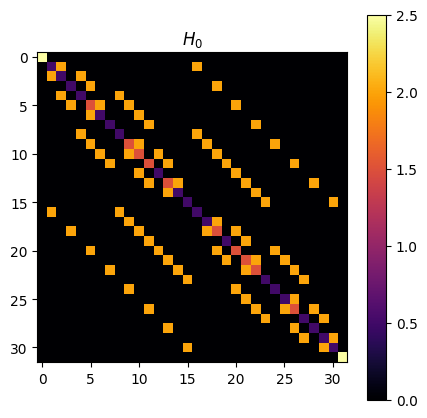

In [7]:
visualize_matrix(h0.matrix, r"$H_0$")

In [8]:
for generator in DoubleBracketGeneratorType:
    print(generator)

DoubleBracketGeneratorType.canonical
DoubleBracketGeneratorType.single_commutator
DoubleBracketGeneratorType.group_commutator
DoubleBracketGeneratorType.group_commutator_third_order


In [9]:
generator_type = DoubleBracketGeneratorType.canonical

#### Execute one step of DBI

In [10]:
dbi = DoubleBracketIteration(hamiltonian=deepcopy(h0), mode=generator_type)

print(f"Off diagonal norm before applying DBI: {dbi.off_diagonal_norm}")
dbi(step=0.01, mode=generator_type)
print(f"Off diagonal norm after applying DBI: {dbi.off_diagonal_norm}")

Off diagonal norm before applying DBI: 17.88854381999832
Off diagonal norm after applying DBI: 17.479773146709526


#### Execute more steps of DBI

In [11]:
def n_db_iterations(dbi, nsteps=30, stepsize=0.01, optimize_step=False, d=None):
    """Repeat `nsteps` times the DBI execution."""
    offdiag_norms = [dbi.off_diagonal_norm]
    for _ in range(nsteps):
        if optimize_step:
            stepsize = optimize_stepsize(dbi=dbi, grid_size=50, d=d)
        dbi(step=stepsize, d=d)
        offdiag_norms.append(dbi.off_diagonal_norm)
    return offdiag_norms

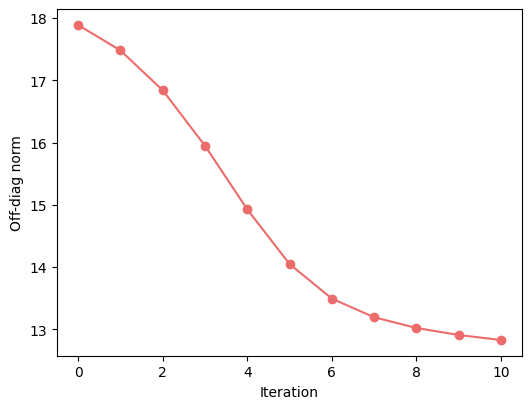

In [12]:
# execute DBI ntimes
dbi = DoubleBracketIteration(hamiltonian=deepcopy(h0), mode=generator_type)
offdiag_norms = n_db_iterations(dbi=dbi, nsteps=nsteps)

# plot the loss function
plot_loss(losses=[offdiag_norms])

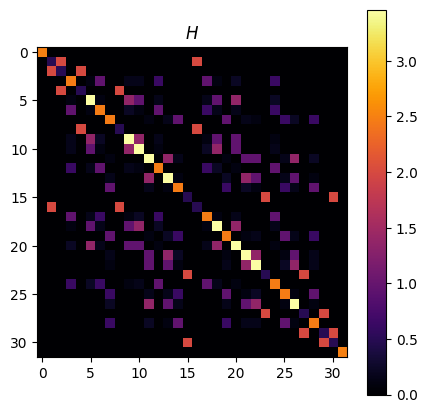

In [13]:
visualize_matrix(dbi.h.matrix, r"$H$")

In [14]:
print(f"Exact ground state energy: {np.min(h0.eigenvalues())}")
print(f"GS Energy according to our diagonalization: {np.real(np.min(dbi.diagonal_h_matrix))}")

Exact ground state energy: -6.280513769031026
GS Energy according to our diagonalization: -3.4610524016659574


#### Optimize the step duration

Let us start by implementing the simpler step optimization ever: a grid search.
This is not optimal, but helps in understanding the importance of hyper-optimizing the DBI. Later in the notebook, we will adopt a smarter strategy to optimize the DBI parameters.

In [15]:
def optimize_stepsize(dbi, d=None, step_range=[-5, 0], grid_size=30):
    """Optimize the stepsize on a grid of values."""
    step_grid = np.logspace(step_range[0], step_range[1], grid_size)

    losses = [dbi.off_diagonal_norm]
    for step in step_grid:
        dbi_copy = deepcopy(dbi)
        dbi_copy(step=step, d=d)
        losses.append(dbi_copy.off_diagonal_norm)

    return step_grid[np.argmin(losses) - 1]

In [16]:
# reset the dbi into the initial configuration
dbi_optimized = DoubleBracketIteration(hamiltonian=deepcopy(h0), mode=generator_type)

# execute ntimes
offdiag_opt = n_db_iterations(dbi=dbi_optimized, nsteps=nsteps, optimize_step=True)

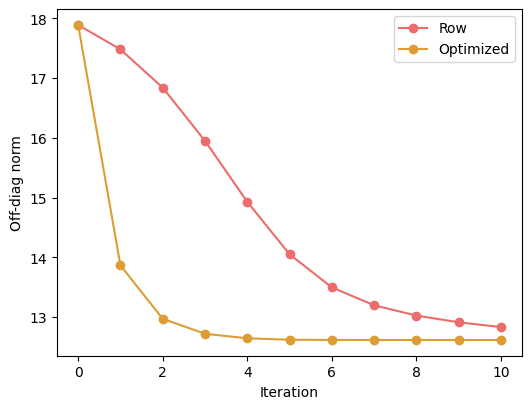

In [17]:
# plot the loss function
plot_loss(losses=[offdiag_norms, offdiag_opt], labels=["Row", "Optimized"])

It seems we can converge faster, but with a similar limit plateau.

#### Let's use a more complicated rotation generator

In [18]:
generator_3order = DoubleBracketGeneratorType.group_commutator_third_order
d_op = np.diag(np.linspace(1,2**nqubits,2**nqubits))
dbi_3order = DoubleBracketIteration(hamiltonian=deepcopy(h0), mode=generator_3order)

In [19]:
offdiag_3order = n_db_iterations(dbi=dbi_3order, nsteps=nsteps, optimize_step=True, d=d_op)

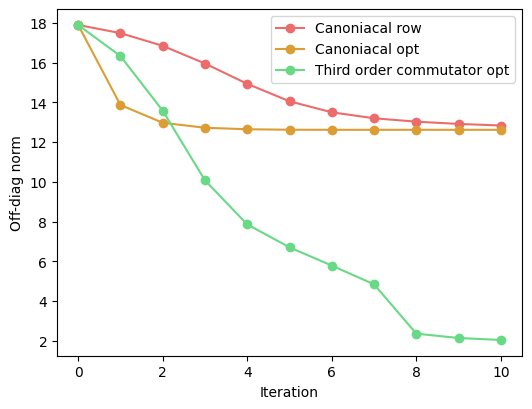

In [20]:
# plot the loss function
plot_loss(
    losses=[offdiag_norms, offdiag_opt, offdiag_3order], 
    labels=["Canoniacal row", "Canoniacal opt", "Third order commutator opt"]
)

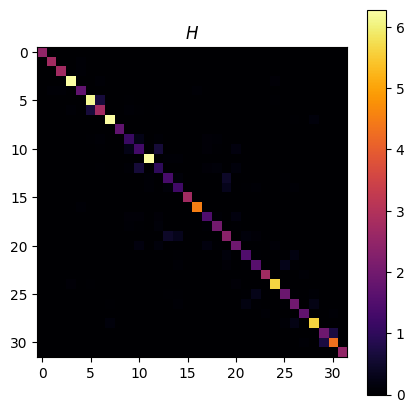

In [21]:
visualize_matrix(dbi_3order.h.matrix, r"$H$")

In [22]:
print(f"Exact ground state energy: {np.min(h0.eigenvalues())}")
print(f"GS Energy according to our diagonalization: {np.real(np.min(dbi_3order.diagonal_h_matrix))}")

Exact ground state energy: -6.280513769031026
GS Energy according to our diagonalization: -6.2791709849819535


#### Parametrize the D operator

In [23]:
from qibo.symbols import Z

def TFIM_d_operator(nqubits, params, print_symbolical=False):
    """
    Parametrize the D operator in form of a classical Transverse Field Ising Model.

    Args:
        nqubits (int): number of qubits;
        params (List[float]): list of coefficients for Z and Z * Z terms in TFIM. 
            It has to be 2 * nqubits long;
    """
    symbolical_d = 0

    for q in range(nqubits):
        symbolical_d += params[::2][q] * Z(q)
        symbolical_d += params[1::2][q] * Z(q) * Z((q + 1) % nqubits)

    if print_symbolical:
        print(symbolical_d)
    
    return hamiltonians.SymbolicHamiltonian(form=symbolical_d).matrix

In [24]:
# random initialization for TFIM
params = np.random.uniform(0., 6., 2 * nqubits)

# setup the D operator
d_op_tfim = TFIM_d_operator(nqubits, params, print_symbolical=True)

5.81529532189296*Z0 + 1.32722496209122*Z0*Z1 + 4.58624317187128*Z1 + 0.679041215799963*Z1*Z2 + 3.37322669645936*Z2 + 3.49445255852994*Z2*Z3 + 0.387664250909977*Z3 + 1.89568565658832*Z3*Z4 + 0.0636030324106436*Z4 + 3.11817711231407*Z4*Z0


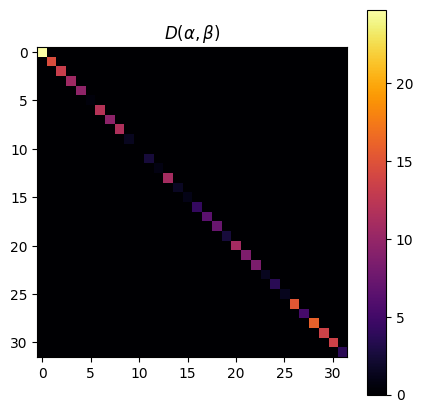

In [25]:
visualize_matrix(d_op_tfim, r"$D(\alpha, \beta)$")

In [26]:
generator_3order = DoubleBracketGeneratorType.group_commutator_third_order
dbi_3order_tfim = DoubleBracketIteration(hamiltonian=deepcopy(h0), mode=generator_3order)

In [27]:
offdiag_3order_tfim = n_db_iterations(dbi=dbi_3order_tfim, nsteps=nsteps, optimize_step=True, d=d_op_tfim)

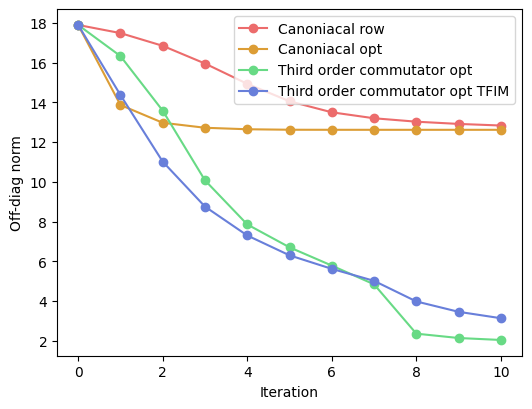

In [28]:
plot_loss(
    losses=[
        offdiag_norms, 
        offdiag_opt, 
        offdiag_3order, 
        offdiag_3order_tfim
    ], 
    labels=[
        "Canoniacal row", 
        "Canoniacal opt", 
        "Third order commutator opt", 
        "Third order commutator opt TFIM"
    ]
)

#### Optimize the D operator

Now that $D$ has been parametrized, we can adopt a variational approach so that we minimize the number of steps required to reach a good diagonalization.

In [29]:
def loss_function_dbi(
    params, 
    dbi
):
    """
    Compute loss function given a DBI configuration, namely given stepsize and the alphas and betas
    which parametrize the D operator.

    Args:
        params (List[float]): variational parameters to be used in the DBI execution.
            The list has to be such that params[0] is the initial stepsize, and then 
            params[1:-1] are (alpha, beta, alpha, beta ...) coefficients of the TFIM parametrization.
        dbi (DoubleBracketIteration): double bracket iteration object.
    """
    dbi_copy = deepcopy(dbi)
    # collect parameters
    d_op = TFIM_d_operator(dbi_copy.h.nqubits, params=params[1:])
    dbi_copy(step=params[0], d=d_op)
    return dbi_copy.off_diagonal_norm

def optimize_DBI(
    dbi, 
    params, 
    method="basinhopping", 
    s_bounds=(1e-4, 1.), 
    b_bounds=(-9., 9.),
):
    """
    Optimize all hyper-parameters of the DBI, namely the stepsize and the alphas and betas
    which parametrize the D operator.
    """

    if method == "cma":
        lower_bounds = s_bounds[0] + b_bounds[0] * (len(params) - 1)
        upper_bounds = s_bounds[1] + b_bounds[1] * (len(params) - 1)
        bounds = [lower_bounds, upper_bounds]
        result = cma.fmin(
            loss_function_dbi,
            sigma0=0.5,
            x0=params,
            args=(dbi,),
            options={"bounds": bounds, "maxiter": 100},
        )[0]
        
    elif method == "basinhopping":
        bounds = [(s_bounds[0], s_bounds[1])]
        for _ in range(len(params) - 1):
            bounds.append((b_bounds[0],b_bounds[1]))

        result = basinhopping(
            func=loss_function_dbi,
            x0=params,
            niter=20,
            minimizer_kwargs={"method": "Powell", "args": (dbi,)},
        ).x

    else:
        bounds = [(s_bounds[0], s_bounds[1])]
        for _ in range(len(params) - 1):
            bounds.append((b_bounds[0],b_bounds[1]))
            
        result = minimize(
            fun=loss_function_dbi,
            x0=params,
            args=(dbi,),
            bounds=bounds,
            method="COBYLA",
            options={"maxiter": 100}
        ).x
    return result

In [30]:
generator_3order_opt = DoubleBracketGeneratorType.group_commutator_third_order
dbi_3order_tfim_opt = DoubleBracketIteration(hamiltonian=deepcopy(h0), mode=generator_3order)

params = [0.01]
params.extend(np.random.uniform(0., 6., nqubits * 2))

offdiag_tfim_opt = [dbi_3order_tfim_opt.off_diagonal_norm]
for n in range(nsteps):
    print(f"Optimized procedure step {n+1}/{nsteps}")
    best_params = optimize_DBI(dbi=dbi_3order_tfim_opt, params=params, method="cma")
    dbi_3order_tfim_opt(step=best_params[0], d=TFIM_d_operator(nqubits, best_params[1:]))
    offdiag_tfim_opt.append(dbi_3order_tfim_opt.off_diagonal_norm)
    clear_output(wait=True)

Optimized procedure step 10/10
(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 11 (seed=403663, Fri Nov 22 22:53:48 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 1.863106870652968e+00 1.0e+00 4.74e-01  5e-01  5e-01 0:00.2
    2     22 1.887713930069176e+00 1.2e+00 4.71e-01  4e-01  5e-01 0:00.4
    3     33 1.860690844572660e+00 1.3e+00 4.45e-01  4e-01  5e-01 0:00.6
   24    264 1.842791493047107e+00 2.9e+00 3.07e-01  1e-01  3e-01 0:03.8
   52    572 1.832134607596579e+00 9.1e+00 3.15e-01  7e-02  4e-01 0:07.9
   85    935 1.819296098096972e+00 2.8e+01 1.77e-01  1e-02  2e-01 0:12.9
  100   1100 1.806753592283091e+00 4.7e+01 2.14e-01  9e-03  3e-01 0:15.2
termination on maxiter=100 (Fri Nov 22 22:54:03 2024)
final/bestever f-value = 1.806644e+00 1.805265e+00 after 1101/1082 evaluations
incumbent solution: [-0.10296027  2.48227804  4.04128223  1.38573767  7.29974523  3.95817094
  1.27152928  2.49983706 ...]
std deviations: [0.00850435 0.28224014

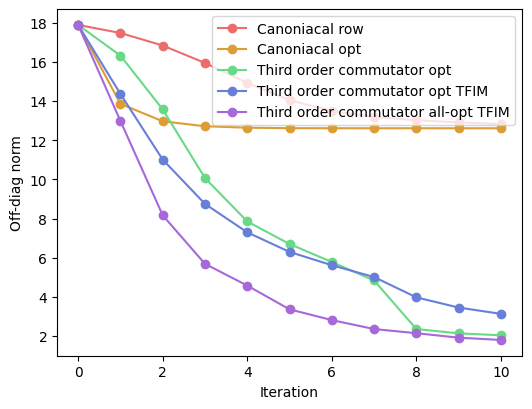

In [31]:
plot_loss(
    losses=[
        offdiag_norms, 
        offdiag_opt, 
        offdiag_3order, 
        offdiag_3order_tfim,
        offdiag_tfim_opt,
    ], 
    labels=[
        "Canoniacal row", 
        "Canoniacal opt", 
        "Third order commutator opt", 
        "Third order commutator opt TFIM",
        "Third order commutator all-opt TFIM",
    ]
)